In [103]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
import torch

print("Using device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Using device: cuda


In [73]:
os.listdir('../dataset')

['eng_dataset.csv', 'README.MD']

#### Data Exploratory

In [74]:
DATASET_PATH = "../dataset/eng_dataset.csv"
try:
  df = pd.read_csv(DATASET_PATH)
except FileNotFoundError:
  print(f'There is not file with the path {DATASET_PATH}')

In [75]:
df.head()

,ID,sentiment,content
0,10941,anger,At the point today where if someone says somet...
1,10942,anger,@CorningFootball IT'S GAME DAY!!!! T MIN...
2,10943,anger,This game has pissed me off more than any othe...
3,10944,anger,@spamvicious I've just found out it's Candice ...
4,10945,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...


In [76]:
categories = ['anger', 'fear', 'sadness', 'joy']

In [77]:
df.isnull().sum()

ID           0
sentiment    0
content      0
dtype: int64

In [78]:
df.duplicated().sum()

0

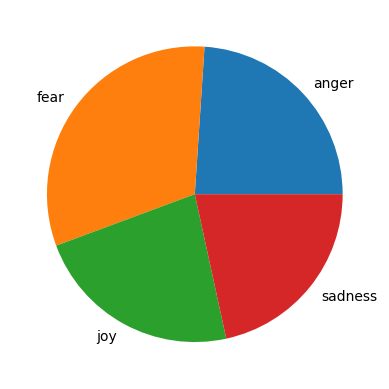

In [79]:
total = df.groupby(['sentiment']).size()

total.plot(kind='pie')

plt.show()

In [80]:
df['content_length'] = df['content'].str.len()

df.head(10)

,ID,sentiment,content,content_length
0,10941,anger,At the point today where if someone says somet...,109
1,10942,anger,@CorningFootball IT'S GAME DAY!!!! T MIN...,67
2,10943,anger,This game has pissed me off more than any othe...,115
3,10944,anger,@spamvicious I've just found out it's Candice ...,101
4,10945,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,135
5,10946,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,142
6,10947,anger,wanna go home and focus up on this game . Don'...,65
7,10948,anger,@virginmedia I've been disconnected whilst on ...,117
8,10949,anger,@virginmedia I've been disconnected whilst on ...,109
9,10950,anger,I wanna see you smile I don't wanna see you ma...,56


In [81]:
def get_word_length(text):
  words = text.split()
  return len(words)

print(f'Word Length Example: {get_word_length(df['content'][0])}')

Word Length Example: 21


In [82]:
df['total_words'] = df['content'].apply(get_word_length)

df.head(10)

,ID,sentiment,content,content_length,total_words
0,10941,anger,At the point today where if someone says somet...,109,21
1,10942,anger,@CorningFootball IT'S GAME DAY!!!! T MIN...,67,8
2,10943,anger,This game has pissed me off more than any othe...,115,23
3,10944,anger,@spamvicious I've just found out it's Candice ...,101,19
4,10945,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,135,21
5,10946,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,142,22
6,10947,anger,wanna go home and focus up on this game . Don'...,65,15
7,10948,anger,@virginmedia I've been disconnected whilst on ...,117,19
8,10949,anger,@virginmedia I've been disconnected whilst on ...,109,18
9,10950,anger,I wanna see you smile I don't wanna see you ma...,56,13


In [83]:
df['mean_word_length'] = df['content'].map(lambda x: np.mean([len(word) for word in x.split()]))

In [84]:
df.head(10)

,ID,sentiment,content,content_length,total_words,mean_word_length
0,10941,anger,At the point today where if someone says somet...,109,21,4.238095
1,10942,anger,@CorningFootball IT'S GAME DAY!!!! T MIN...,67,8,6.625000
2,10943,anger,This game has pissed me off more than any othe...,115,23,4.043478
3,10944,anger,@spamvicious I've just found out it's Candice ...,101,19,4.368421
4,10945,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,135,21,5.428571
5,10946,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,142,22,5.500000
6,10947,anger,wanna go home and focus up on this game . Don'...,65,15,3.400000
7,10948,anger,@virginmedia I've been disconnected whilst on ...,117,19,5.210526
8,10949,anger,@virginmedia I've been disconnected whilst on ...,109,18,5.055556
9,10950,anger,I wanna see you smile I don't wanna see you ma...,56,13,3.384615


In [85]:
stop_words = stopwords.words("english")
stop_words.append("amp")

def tokenize(text):
  words = word_tokenize(text)
  return words

def remove_stopwords(words) -> [str]:
  words = [word for word in words if word not in stop_words and word.isalpha()]
  return words

def process_text(text) -> str:
  words = tokenize(text)
  words = remove_stopwords(words)

  return ' '.join(words)

In [86]:
df['content'] = df['content'].apply(process_text)
df.head(10)

,ID,sentiment,content,content_length,total_words,mean_word_length
0,10941,anger,At point today someone says something remotely...,109,21,4.238095
1,10942,anger,CorningFootball IT GAME DAY T MINUS relentless,67,8,6.625000
2,10943,anger,This game pissed game year My blood boiling Ti...,115,23,4.043478
3,10944,anger,spamvicious I found Candice Candace She pout l...,101,19,4.368421
4,10945,anger,moocowward mrsajhargreaves GaryBarlow ca come ...,135,21,5.428571
5,10946,anger,moocowward mrsajhargreaves GaryBarlow ca come ...,142,22,5.500000
6,10947,anger,wan na go home focus game Do wan na rage,65,15,3.400000
7,10948,anger,virginmedia I disconnected whilst holiday I mo...,117,19,5.210526
8,10949,anger,virginmedia I disconnected whilst holiday I mo...,109,18,5.055556
9,10950,anger,I wan na see smile I wan na see make frown,56,13,3.384615


In [87]:
words = " ".join(df['content'])

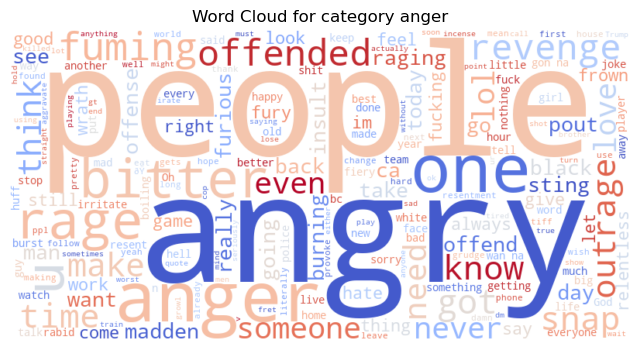

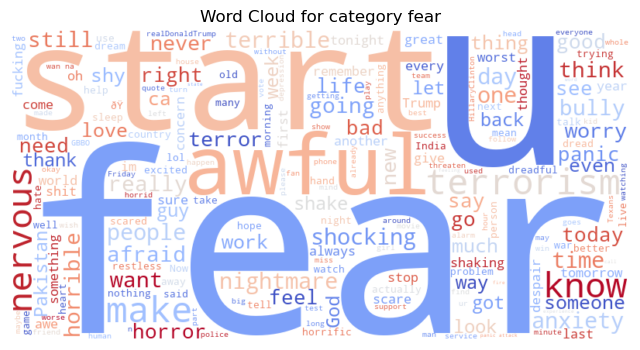

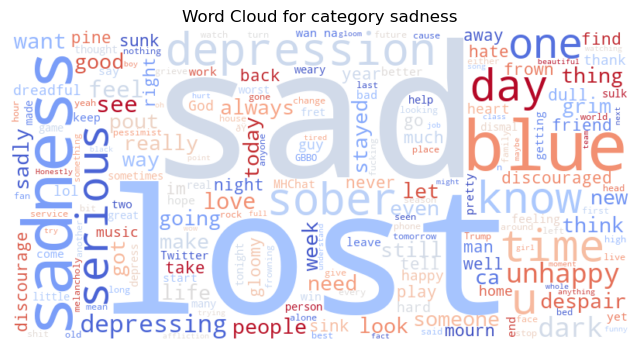

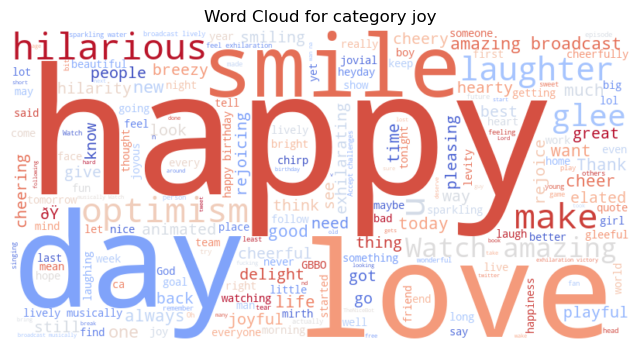

In [88]:
for category in categories:
  words = " ".join(df['content'][df['sentiment'] == category])

  wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='coolwarm').generate(words)

  plt.figure(figsize=(8, 8))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')  # Hide axes
  plt.title(f'Word Cloud for category {category}')
  plt.show()

#### Encode label.

In [89]:
label_encoder = LabelEncoder()

df['labels'] = label_encoder.fit_transform(df['sentiment'])

In [90]:
df

,ID,sentiment,content,content_length,total_words,mean_word_length,labels
0,10941,anger,At point today someone says something remotely...,109,21,4.238095,0
1,10942,anger,CorningFootball IT GAME DAY T MINUS relentless,67,8,6.625000,0
2,10943,anger,This game pissed game year My blood boiling Ti...,115,23,4.043478,0
3,10944,anger,spamvicious I found Candice Candace She pout l...,101,19,4.368421,0
4,10945,anger,moocowward mrsajhargreaves GaryBarlow ca come ...,135,21,5.428571,0
...,...,...,...,...,...,...,...
7097,40781,sadness,VivienLloyd Thank much Just home stunned happy...,102,20,4.150000,3
7098,40782,sadness,Just put winter duvet,37,7,4.285714,3
7099,40783,sadness,SilkInSide TommyJoeRatliff pretty I love sky b...,135,22,5.181818,3
7100,40784,sadness,BluesfestByron second artist announcement look...,94,10,8.500000,3


#### Training Using Bert-Based

In [91]:
MODEL_NAME = "michellejieli/emotion_text_classifier"

In [92]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [93]:
dataset = Dataset.from_pandas(df[['content', 'labels']])

dataset[0]

{'content': 'At point today someone says something remotely kind waterfall burst eyes',
 'labels': 0}

In [94]:
def tokenize_words(data):
  return tokenizer(data['content'], truncation=True, padding="max_length")

tokenized_datasets = dataset.map(tokenize_words, batched=True)

Map: 100%|██████████| 7102/7102 [00:01<00:00, 5555.40 examples/s]


In [95]:
tokenized_datasets[0]

{'content': 'At point today someone says something remotely kind waterfall burst eyes',
 'labels': 0,
 'input_ids': [0,
  3750,
  477,
  452,
  951,
  161,
  402,
  18684,
  761,
  35076,
  10084,
  2473,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,


In [96]:
split_dataset = tokenized_datasets.train_test_split(test_size=0.2)

train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

In [97]:
len(train_dataset), len(test_dataset)

(5681, 1421)

In [106]:
training_arguments = TrainingArguments(
  output_dir="./emotion_model",
  evaluation_strategy="epoch",
  save_strategy="epoch",
  learning_rate=2e-5,
  per_device_train_batch_size=8,
  per_device_eval_batch_size=8,
  num_train_epochs=3,
  weight_decay=0.01,
  fp16=True,
)

c:\Users\PC GEMING\anaconda3\envs\deep_learning\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [107]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
  model=model,
  args=training_arguments,
  train_dataset=train_dataset,
  eval_dataset=test_dataset,
  tokenizer=tokenizer,
  data_collator=data_collator
)

C:\Users\PC GEMING\AppData\Local\Temp\ipykernel_16684\732236951.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [108]:
trainer.model.device

device(type='cuda', index=0)

In [109]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 